In [13]:
#importing libraries
import numpy as np
import tensorflow as tf
from google.colab import drive
import zipfile
import os

In [19]:
#Load and Pre-process the dataset
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [20]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

In [21]:
len(os.listdir('/content/dataset/'))

2

In [22]:
batch_size = 32
img_height = 180
img_width = 180

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1376 files belonging to 2 classes.
Using 1101 files for training.


In [25]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


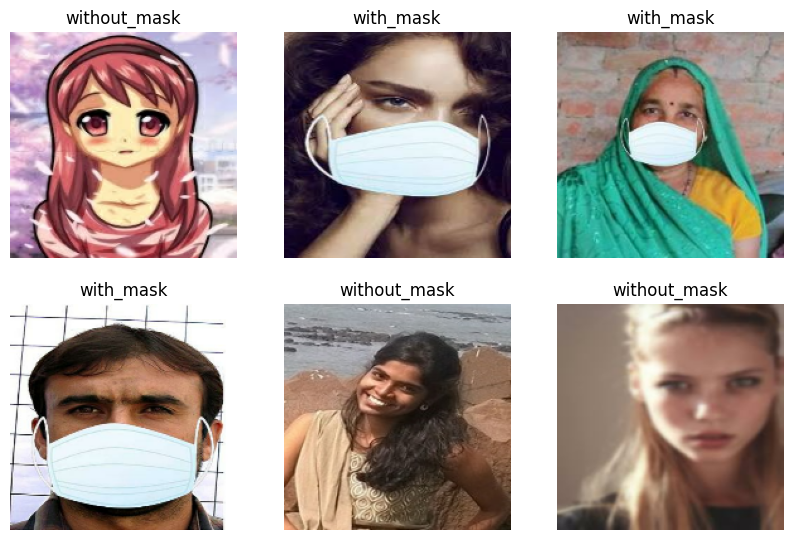

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [28]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0014204321 1.0


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1376 files belonging to 2 classes.
Using 275 files for validation.


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [84]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [89]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    name="Adam"
)
model.compile(
  optimizer=Adam,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [90]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  callbacks=[callback],
  verbose=0
)
len(history.history['loss'])

29

In [91]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


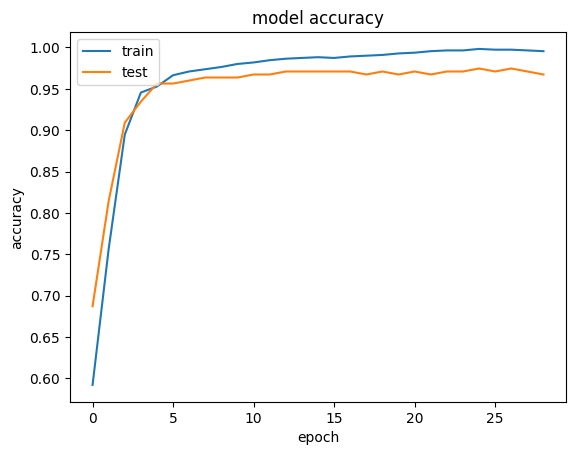

In [92]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

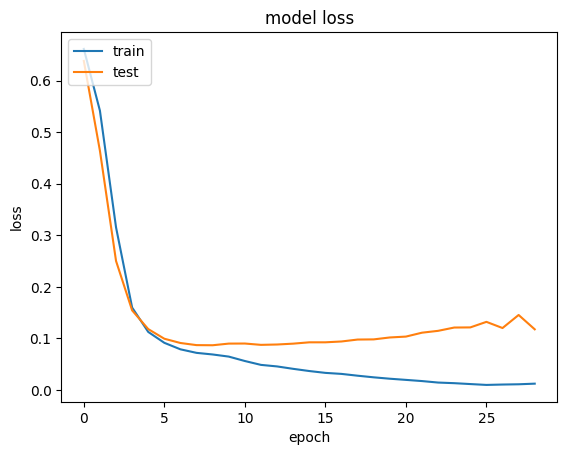

In [93]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
print("Evaluate on test data")
results = model.evaluate(val_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
9/9 [==============================] - 3s 361ms/step - loss: 0.1178 - accuracy: 0.9673
test loss, test acc: [0.11776687949895859, 0.9672726988792419]


In [95]:
model.save('/content/drive/MyDrive')